# <center> Тестовое задание </center>

Вы работатете ML-инженером в онлайн-кинотеатре. Один из способов привлечения пользователей – триальный период, 7 дней бесплатного полного доступа к сервису. Далее пользователь либо покупает платную подписку, либо покидает сервис.

В файле содержатся данные о конверсии пользователей из триального периода в покупку первой подписки.

## Колонки в данных:
 - user_id: str, id пользователя;
 - start_trial_date: str, день начала триального периода пользователя;
 - source: str, источик появления пользователя на сервисе;
 - device: str, устройство, с которого пользователь зарегистрировался;
 - city: str, город, из которого пользователь зарегистрировался;
 - favourite_genre: str, любимый жанр, указанный пользователем при регистрации;
 - avg_min_watch_daily: float, среднее число минут просмотра в день в течение триального периода;
 - number_of_days_logged: int, количество дней в течение триального пероида, когда пользователь логировался на сервисе;
 - churn: int, купил ли пользователь подписку по окончании триального периода (0) или нет (1).

Требуется на основе этих данных построить модель предсказания оттока пользователей онлайн-видеостриминга.

## Какие шаги хотелось бы видеть в отчёте:
1. EDA: 
  - распределение значений признаков;
  - взаимосвязь признаков друг с другом и целевой переменной;
2. Подготовка данных: 
  - обработка категориальных признаков;
  - обработка числовых признаков;
  - преобразование дат;
  - обработка пустых значений и выбросов;
3. Обучение модели: 
  - проработка схемы валидации;
  - обучение бустинга;
  - обучение нейросети;
4. Сравнение качества работы обученного бустинга и нейросети.

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
plt.style.use("cyberpunk")

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import torch
import torchutils as tu
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc, f1_score, precision_recall_curve
import optuna
from datetime import datetime
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Знакомство с данными

Подгружаем данные

In [316]:
url = 'https://drive.usercontent.google.com/u/0/uc?id=1DQJ0lF_bsCBsTw4YCfZx_yJdRa0MCeqD&export=download'
df = pd.read_csv(url)
df.head(5)

,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
0,d1b6ef34-1991-452a-8c39-c83c0d5805fe,2024-02-01,St Petersburg,ios,performance,drama,2.076642,4,1
1,f1bf2396-73d8-461e-a775-9f068bd99326,2024-02-01,Other,web,seo,criminal,5.101392,1,1
2,ec9fa0be-4bd8-4fe6-910a-e9e6d4bbba28,2024-02-01,Ufa,web,performance,criminal,2.906597,1,1
3,b0195e96-af2e-4ac3-8f60-26b8d862af84,2024-02-01,Moscow,smarttv,seo,thriller,2.702388,6,0
4,a208985a-7244-4291-8d38-64c8141e27b2,2024-02-01,Ufa,web,performance,thriller,10.237305,1,1


Удалим дубликаты

In [317]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                28000 non-null  object 
 1   start_trial_date       28000 non-null  object 
 2   city                   27692 non-null  object 
 3   device                 28000 non-null  object 
 4   source                 28000 non-null  object 
 5   favourite_genre        20048 non-null  object 
 6   avg_min_watch_daily    28000 non-null  float64
 7   number_of_days_logged  28000 non-null  int64  
 8   churn                  28000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 1.9+ MB


In [318]:
df.isnull().sum()

user_id                     0
start_trial_date            0
city                      308
device                      0
source                      0
favourite_genre          7952
avg_min_watch_daily         0
number_of_days_logged       0
churn                       0
dtype: int64

Посмотрим распределение таргета

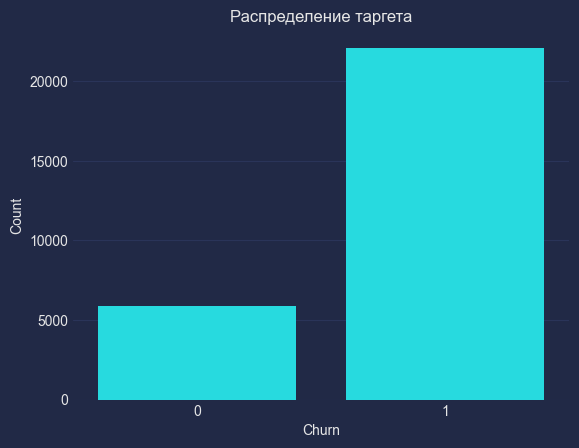

In [319]:
sns.countplot(x='churn', data=df)
plt.title('Распределение таргета')
plt.xlabel('Сhurn')
plt.ylabel('Count')
plt.show()

#### Выводы:  
В данных есть пропуски (city - 308, favourite_genre - 7952), которые нужно постараться заполнить.  
Дубликатов не обнаружено.  
Признак start_trial_date содержит дату, которую нужно преобразовать в данные, кототрые могут использоваться для обучения модели. Как вариант, разбить этот признак на 3 признака год, месяц, день.
Таргет имеет классовый дизбаланс. Задача представляет собой бинарную классификацию, в связи с этим лучше использовать ROC_AUC, f1_score, PR_AUC в качестве метрик для оценки модели.

### 2. Предобработка

Заполним пропуски признака city. Посмотрим на уникальные значения признака.

In [320]:
df[['user_id', 'city']].groupby('city').count()

,user_id
city,
Krasnodar,2575
Moscow,8736
Novosibirsk,2213
Other,2660
Samara,1876
St Petersburg,4480
Ufa,1652
Voronezh,1568
Yekaterinburg,1932


Как видим, у признака есть значение Other. Принято решщение заполнить пропуски этим значением.

In [321]:
df['city'].fillna('Other', inplace=True)
print(f"Пропущено значений {df['city'].isnull().sum()}")
df['city'].unique()

Пропущено значений 0


array(['St Petersburg', 'Other', 'Ufa', 'Moscow', 'Samara', 'Krasnodar',
       'Yekaterinburg', 'Novosibirsk', 'Voronezh'], dtype=object)

Обработаем признак start_trial_date, разбив его на 3 признака год, месяц, день. После удалим исходный признак.

In [322]:
df['start_trial_date'] = pd.to_datetime(df['start_trial_date'])

df['start_year'] = df['start_trial_date'].dt.year
df['start_month'] = df['start_trial_date'].dt.month
df['start_day'] = df['start_trial_date'].dt.day

df.drop(columns=['start_trial_date'], inplace=True)

In [323]:
df.head(3)

,user_id,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn,start_year,start_month,start_day
0,d1b6ef34-1991-452a-8c39-c83c0d5805fe,St Petersburg,ios,performance,drama,2.076642,4,1,2024,2,1
1,f1bf2396-73d8-461e-a775-9f068bd99326,Other,web,seo,criminal,5.101392,1,1,2024,2,1
2,ec9fa0be-4bd8-4fe6-910a-e9e6d4bbba28,Ufa,web,performance,criminal,2.906597,1,1,2024,2,1


 Признака favourite_genre имеет достаточно большое количество пропусков. Для начала можно посмотреть частотность всех жанров.

In [324]:
df[['user_id', 'favourite_genre']].groupby('favourite_genre').count()

,user_id
favourite_genre,
action,3612
comedy,4284
criminal,3052
drama,4928
thriller,4172


Нет ярко выраженного преобладающего жанра. В связи с этим, заполнение модой может привести к искажению реальных данных.  
  
Как вариант, можно проанализировать частотность жанров в какой-то из групп. Лучше отталкиваться от категориальных признаков (city, device, source). Разбивать жанр по группам устройств и источников регистрации будет странно, но можно разбить по городам.
  
Ниже количество пропущенных значений favourite_genre по городам.

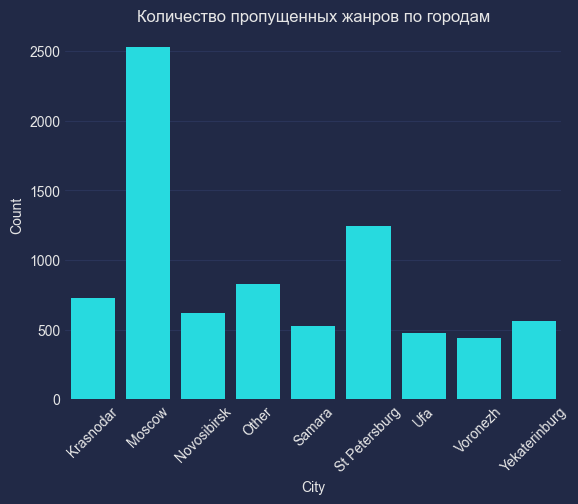

In [325]:
missing_values_city = df.groupby('city')['favourite_genre'].apply(lambda x: x.isnull().sum())

sns.barplot(data=missing_values_city)
plt.title('Количество пропущенных жанров по городам')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

Посмотрим на частотность жанров в каждом городе и найдем моду для каждого города

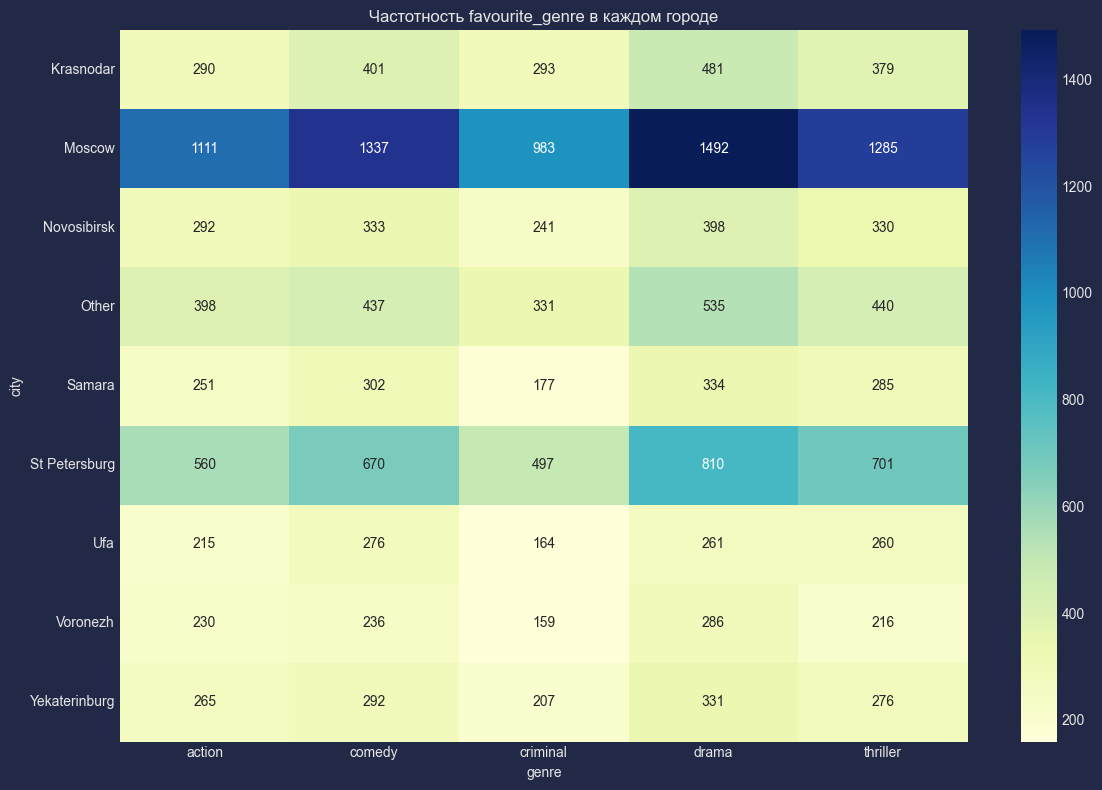

In [326]:
genre_counts_city = df.groupby('city')['favourite_genre'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(genre_counts_city, annot=True, fmt="g", cmap='YlGnBu')
plt.title('Частотность favourite_genre в каждом городе')
plt.xlabel('genre')
plt.ylabel('city')
plt.tight_layout()
plt.show()

In [327]:
genre_counts_city.idxmax(axis=1)

city
Krasnodar         drama
Moscow            drama
Novosibirsk       drama
Other             drama
Samara            drama
St Petersburg     drama
Ufa              comedy
Voronezh          drama
Yekaterinburg     drama
dtype: object

Из анализа видно, что во всех городах, исключая Уфу преобладает жанр drama. В Уфе преобладает жанр comedy. В регионах по прежнему нет отчетливого преобладания какого-то из жанров.

Заполним пропуски модой для каждого города.

In [328]:
df['favourite_genre'] = df.groupby('city')['favourite_genre'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                28000 non-null  object 
 1   city                   28000 non-null  object 
 2   device                 28000 non-null  object 
 3   source                 28000 non-null  object 
 4   favourite_genre        28000 non-null  object 
 5   avg_min_watch_daily    28000 non-null  float64
 6   number_of_days_logged  28000 non-null  int64  
 7   churn                  28000 non-null  int64  
 8   start_year             28000 non-null  int32  
 9   start_month            28000 non-null  int32  
 10  start_day              28000 non-null  int32  
dtypes: float64(1), int32(3), int64(2), object(5)
memory usage: 2.0+ MB


Пропуски успешно заполнены

### 4. EDA

Посмотрим на количество уникальных значений user_id

In [329]:
df['user_id'].nunique()

28000

Каждое значение user_id уникально. Сохраним его в отдельный вектор и удалим из данных для обучения предсказательной модели.

In [330]:
user_id = df['user_id']
df.drop(columns=['user_id'], inplace=True)

Разделим признаки на числовые и категориальные

In [331]:
numeric_features = df.select_dtypes('number')
categorical_features = df.select_dtypes('object')

Посмотрим на распределение числовых признаков

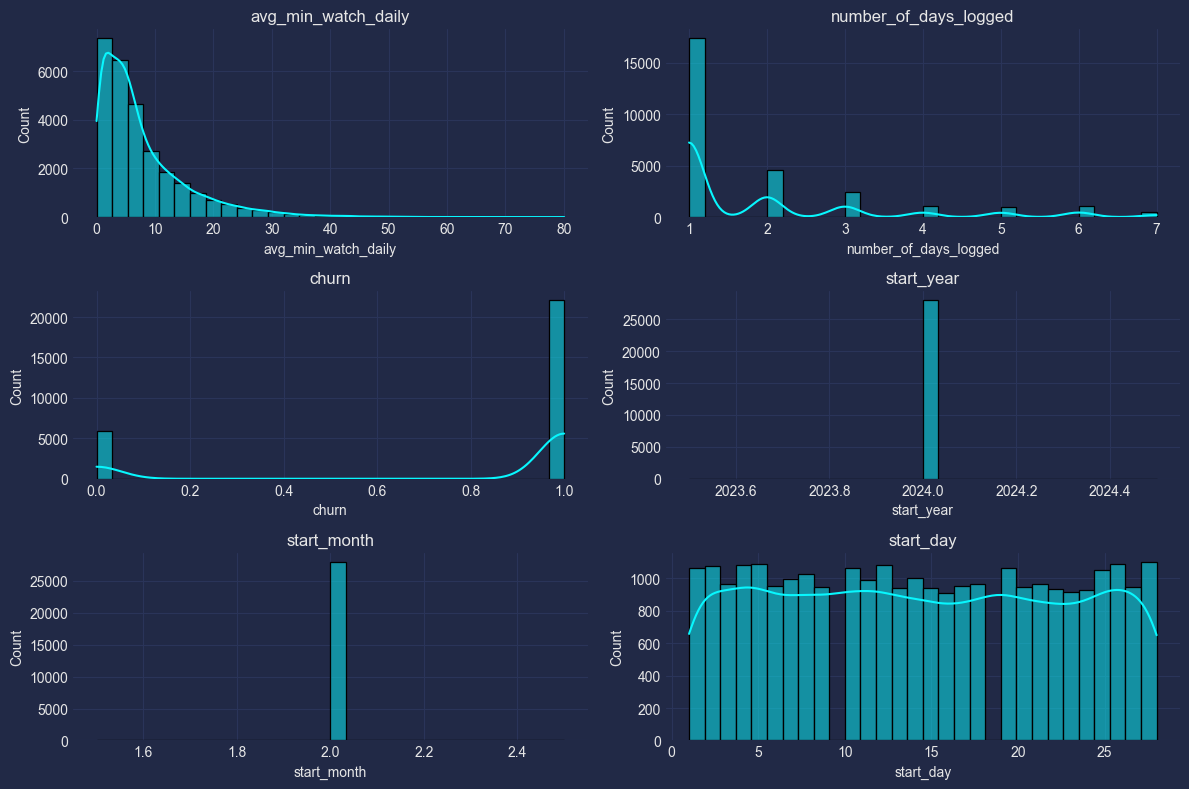

In [332]:
fig, axes = plt.subplots(round(len(numeric_features.columns) / 2), 2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(numeric_features.columns):
        sns.histplot(numeric_features[numeric_features.columns[i]], kde=True, ax=ax, bins=30)
        ax.set_title(numeric_features.columns[i])

fig.tight_layout()
plt.show();

Из распределения видно, что start_year и start_month имеют только одно уникальное значение, следовательно не внесут вклад в обучение. Удалим эти признаки.  

In [333]:
df.drop(columns=['start_month', 'start_year'], inplace=True)

Посмотрим на распределение категориальных признаков

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


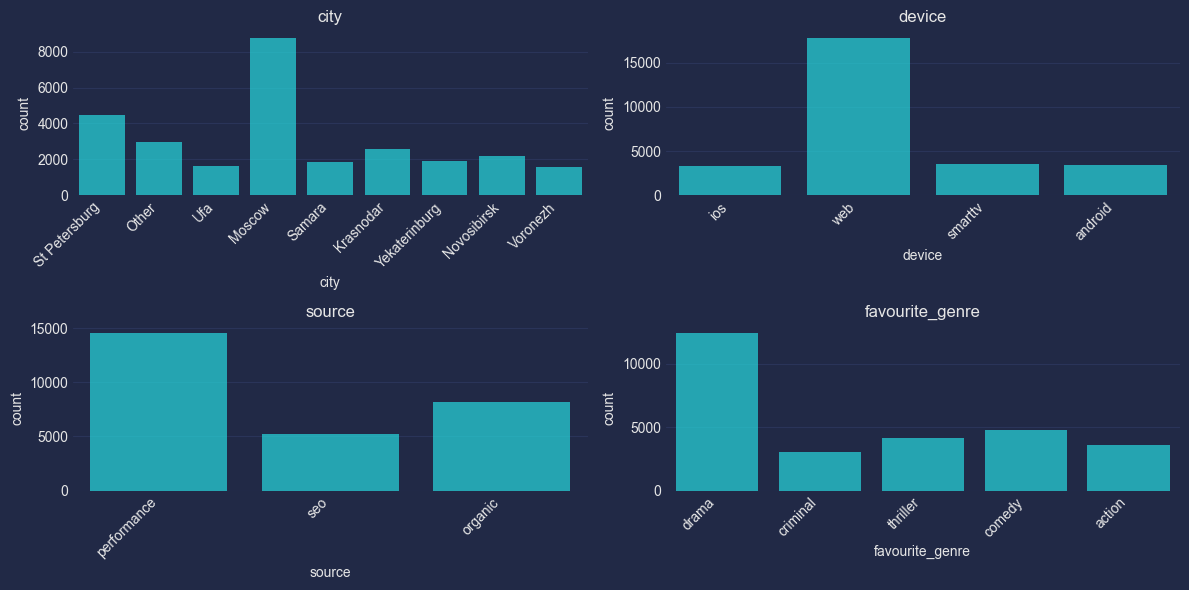

In [334]:
fig, axes = plt.subplots(round(len(categorical_features.columns) / 2), 2, figsize=(12, 6))

for i, ax in enumerate(fig.axes):
    if i < len(categorical_features.columns):
        sns.countplot(x=categorical_features.columns[i], alpha=0.7, data=categorical_features, ax=ax)
        ax.set_title(categorical_features.columns[i])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
plt.show();

Из распределения можно сделать вывод, что основная масса пользователей из МСК. И большая часть пользуется web сервисом.  
  
Построим матрицу корреляции.

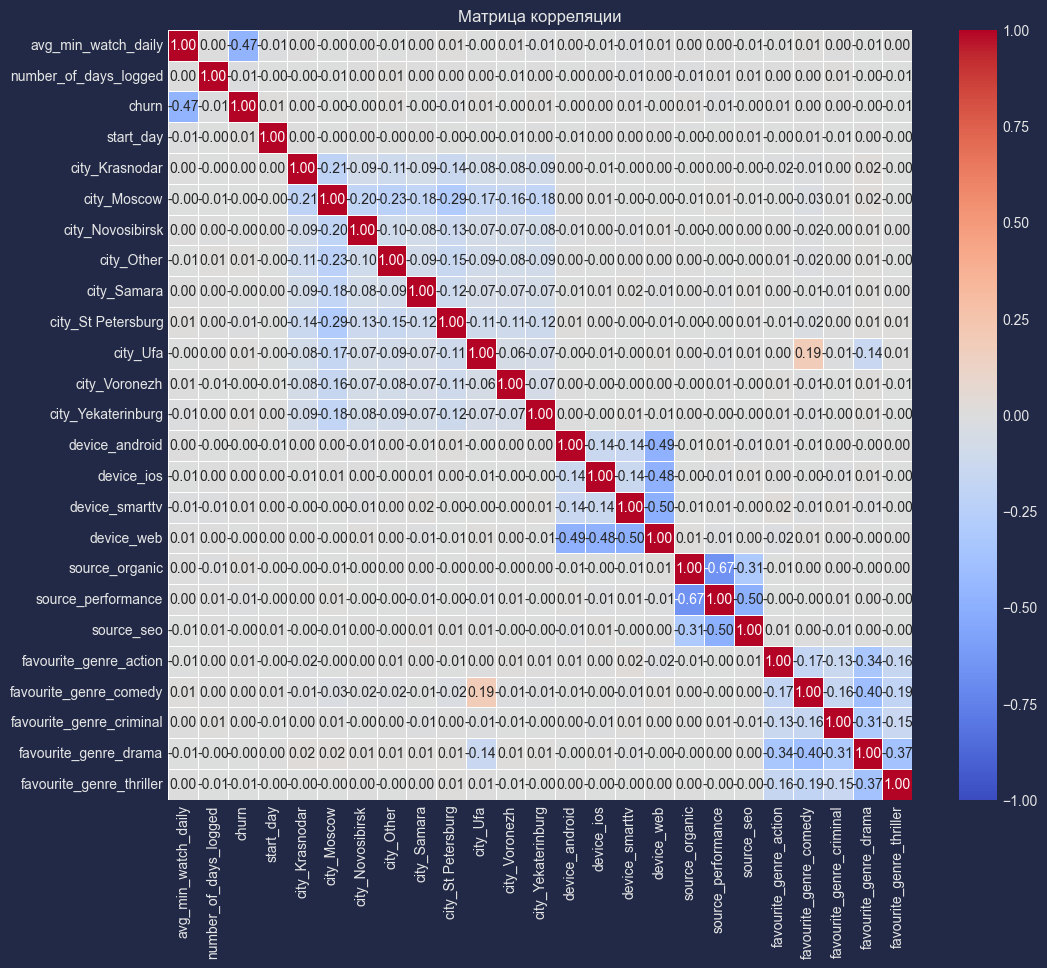

In [335]:
corr_matrix = pd.get_dummies(df, columns=['city', 'device', 'source', 'favourite_genre']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляции')
plt.show()

Исходя из матрицы корреляции, с таргетом заметно коррелирует только признак avg_min_watch_daily. Проведем стат тесты, чтобы отбросить признаки не имеющие статистической значимости.  

### 4. Статистика

Т.к. решается задача бинарной классификации для числовых признаков проведем t-test, а для категориальной chi2. Все признаки, которые не имеют статистического значения соберем в отдельный список.

In [336]:
drop_list = []
for num_feature in df.select_dtypes('number').columns.tolist():
    group_1 = df[df['churn'] == 1][num_feature]
    group_2 = df[df['churn'] == 0][num_feature]
    t_statistic, p_value = ttest_ind(group_1, group_2, equal_var=False)
    if p_value >= 0.05:
        drop_list.append(num_feature)
drop_list

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


['start_day']

In [337]:
for cat_feature in df.select_dtypes('object').columns.tolist():
    contingency_table = pd.crosstab(df[cat_feature], df['churn'])

    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    if p_value >= 0.05:
        drop_list.append(cat_feature)

drop_list

['start_day', 'city', 'device', 'source', 'favourite_genre']

Отбрасывать все признаки за исключением 2-х опираясь только на стат тесты рискованно, т.к. данные могут иметь сложные нелинейные связи.  
Опираясь на собственный опыт, для такого набора данных стат тестам можно доверять, но будем опираться на цифры. Оставим 2 датасета:  
- оставим все признаки
- отбросим признаки, которые не являются статически значимыми

In [338]:
df_crop = df.drop(columns=drop_list)

In [339]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avg_min_watch_daily    28000 non-null  float64
 1   number_of_days_logged  28000 non-null  int64  
 2   churn                  28000 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 656.4 KB


### 5. Кодирование категориальных перменных и масштабирование данных

Перед кодированием переменных разобьем выборки на тренировочную и валидационную части

In [340]:
X, y = df.drop('churn', axis=1), df['churn']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=666)

X_c, y_c = df_crop.drop('churn', axis=1), df_crop['churn']
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_c, y_c, test_size=0.2, random_state=666)

Соберем кодировщик для датасета с полным набором признаков.  
Используем таргет кодировщик для кодирования категориальных переменных

In [341]:
target = X.select_dtypes('object').columns.tolist()

my_encoder = ColumnTransformer(
    [
        ('target_encoding_columns', TargetEncoder(), target)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

Нормализация числовых признаков улучшит качество модели. Для этого используем MinMaxScaler, т.к. он лучше подходит для, когда данные не имеют нормального распределения.

In [342]:
my_scaler = ColumnTransformer(
    [
        ('scaling_num_columns', MinMaxScaler(), X.select_dtypes('number').columns.tolist())
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

Соберем препроцессор для выборки с полным набором признаков

In [343]:
my_preprocessor = Pipeline(
    [
        ('encoder', my_encoder),
        ('scaler', my_scaler)
    ]
)

### 5. ML секция

Обучим несколько моделей на датасетах и без и оценим точность предсказания. В качестве моделей выбраны:  
- logistic regression, как быстрый инструмент, который может показать хорошую точность на данных, которые не имеют сложных нелинейностей, как текущие.
- random forest, как представитель моделей бэггинга
- catboot, как представитель моделей бустинга  
  
Для более объективной оценки метрики используем кросс валидацию.

Начнем с данных, содержащих полный набор признаков.

In [344]:
rf = RandomForestClassifier(n_estimators=30, random_state=1)
cb = CatBoostClassifier(eval_metric='AUC', verbose=False)
lr = LogisticRegression()

models = [rf, cb, lr]
cv = KFold(n_splits=5, random_state=96, shuffle=True)

result_list = []
for i in models:
    ml_pipeline = Pipeline(
        [
            ('preprocessor', my_preprocessor),
            ('model', i)
        ]
    )

    y_pred = cross_val_predict(ml_pipeline, X_train, y_train, cv=cv, method='predict')
    y_prob = cross_val_predict(ml_pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

    cv_f1 = f1_score(y_train, y_pred)
    cv_roc_auc = roc_auc_score(y_train, y_prob)

    precision, recall, _ = precision_recall_curve(y_train, y_prob)
    cv_pr_auc = auc(recall, precision)

    result_list.append({
        'roc_auc': round(cv_roc_auc, 3),
        'f1_score': round(cv_f1, 3),
        'pr_auc': round(cv_pr_auc, 3)
    })

cross_score = pd.DataFrame(result_list, index=['RandomForest', 'CatBoost', 'LogisticRegression'])
cross_score

,roc_auc,f1_score,pr_auc
RandomForest,0.774,0.878,0.923
CatBoost,0.809,0.888,0.938
LogisticRegression,0.820,0.892,0.943


Повторим операцию для данных, с урезанным набором признаков

In [345]:
rf = RandomForestClassifier(n_estimators=30, random_state=1)
cb = CatBoostClassifier(eval_metric='AUC', verbose=False)
lr = LogisticRegression()

models = [rf, cb, lr]
cv = KFold(n_splits=5, random_state=96, shuffle=True)

result_list = []
for i in models:
    ml_pipeline = Pipeline(
        [
            ('preprocessor', MinMaxScaler()),
            ('model', i)
        ]
    )

    y_pred = cross_val_predict(ml_pipeline, X_train_c, y_train_c, cv=cv, method='predict')
    y_prob = cross_val_predict(ml_pipeline, X_train_c, y_train_c, cv=cv, method='predict_proba')[:, 1]

    cv_f1 = f1_score(y_train_c, y_pred)
    cv_roc_auc = roc_auc_score(y_train_c, y_prob)

    precision, recall, _ = precision_recall_curve(y_train_c, y_prob)
    cv_pr_auc = auc(recall, precision)

    result_list.append({
        'roc_auc': round(cv_roc_auc, 3),
        'f1_score': round(cv_f1, 3),
        'pr_auc': round(cv_pr_auc, 3)
    })

cross_score_c = pd.DataFrame(result_list, index=['RandomForest', 'CatBoost', 'LogisticRegression'])
cross_score_c

,roc_auc,f1_score,pr_auc
RandomForest,0.722,0.844,0.913
CatBoost,0.815,0.890,0.941
LogisticRegression,0.820,0.892,0.943


Как и следовало ожидать, набор данных с урезанным набором признаков показывает аналогичные результаты по отношению к полному набору данных. Более того, лучшие результаты показывает линейная регрессия, что говорит о отсутствии сложных нелинейных связей в данных.  
  
Т.к. это тестовое задание ниже блок кода с оптимизацией параметров модели, но это не приведет к значительному улучшению метрик.

In [346]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
results_list = []

def objective(trial):
    classifier_name = 'LogisticRegression'
    
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
        classifier_obj = LogisticRegression(C=C, penalty=penalty, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
    else:
        classifier_obj = LogisticRegression(C=C, penalty=penalty, solver='liblinear' if penalty == 'l1' else 'lbfgs', max_iter=10000)

    ml_pipeline = Pipeline([
        ('preprocessor', MinMaxScaler()),
        ('model', classifier_obj)
    ])

    cv = KFold(n_splits=5, random_state=666, shuffle=True)
    scoring_metric = 'roc_auc'
    scores = cross_val_score(ml_pipeline, X_train_c, y_train_c, cv=cv, scoring=scoring_metric)
    roc_auc = scores.mean()
    
    global results_list
    results_list.append({'Classifier': classifier_name, 'ROC_AUC': roc_auc})
    
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_value = study.best_value

print("Best Params:", best_params)
print("Best ROC_AUC:", best_value)

Best Params: {'C': 0.011151856117888957, 'penalty': 'l1'}
Best ROC_AUC: 0.8202910475963441


Проведем валидацию на лучших параметрах модели

In [347]:
if best_params['penalty'] == 'elasticnet':
    l1_ratio = best_params.get('l1_ratio', 0.5)
    model_lr = LogisticRegression(C=best_params['C'], penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, max_iter=10000)
else:
    model_lr = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear' if best_params['penalty'] == 'l1' else 'lbfgs', max_iter=10000)

pipeline = Pipeline([
    ('preprocessor', MinMaxScaler()),
    ('model', model_lr)
])

pipeline.fit(X_train_c, y_train_c)

y_pred_valid = pipeline.predict(X_valid_c)
y_prob_valid = pipeline.predict_proba(X_valid_c)[:, 1]

cv_f1 = f1_score(y_valid_c, y_pred_valid)
cv_roc_auc = roc_auc_score(y_valid_c, y_prob_valid)

precision, recall, _ = precision_recall_curve(y_valid_c, y_prob_valid)
cv_pr_auc = auc(recall, precision)

print(f"'roc_auc': {round(cv_roc_auc, 3)}, 'f1_score': {round(cv_f1, 3)}, 'pr_auc': {round(cv_pr_auc, 3)}")

'roc_auc': 0.814, 'f1_score': 0.895, 'pr_auc': 0.945


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


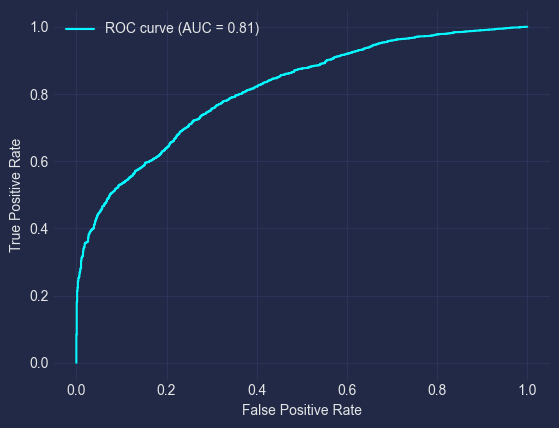

In [348]:
fpr, tpr, thresholds = roc_curve(y_valid_c, y_prob_valid)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.legend([f'ROC curve (AUC = {roc_auc:.2f})'])
plt.show();

Использовать shap для визуализации признаков и их распределения, которые внесли основной вклад в обучение модели не имеет смысла, т.к. признака всего 2.  

### 6. DL секция

Построение нейронной сети не приведет к улучшению результатов, относительно логистической регрессии, т.к. нейронные сети предназначены для поиска сложных нелинейных зависимостей, которых нет в этом наборе данных.  
  
Соберем простую однослойную нейронную сеть.

In [349]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
nn_model = SimpleNN(input_dim=len(X_c.columns))

tu.get_model_summary(nn_model, torch.randn(32, len(X_c.columns)))

Layer       Kernel   Output    Params   FLOPs
0_linear    [2, 1]   [32, 1]        3      96
1_sigmoid        -   [32, 1]        0     128
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total FLOPs: 224 / 0.22 KFLOPs
---------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Представим тренировочный и валидационный набор данных в виде тензоров и добавим их в загрузчик

In [350]:
train_ds = TensorDataset(torch.tensor(X_train_c.values, dtype=torch.float), torch.tensor(y_train_c.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_valid_c.values, dtype=torch.float), torch.tensor(y_valid_c.values, dtype=torch.float))

train_loader = DataLoader(train_ds, shuffle=True, batch_size=128)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=128)

Напишем функцию для отображения графика функции потерь и метрики

In [351]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(tm, label='Train ROC AUC')
    ax[1].plot(vm, label='Valid ROC AUC')
    ax[1].legend()
    ax[1].set_title('Accuracy')

Создадим оптимизатор и укажем функцию потерь. Т.к. задача - бинарная классификация, функция потерь - бинарная кросс энтропия.

In [352]:
optimizer = optim.Adam(nn_model.parameters(), lr=0.005)
criterion = nn.BCELoss()

Напишем функцию обучения сети с сохранением значиний функции потерь и метрики для каждой эпохи обучения

In [353]:
def train_nn_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs):
    train_losses = []
    valid_losses = []
    train_roc_auc = []
    valid_roc_auc = []

    for epoch in range(n_epochs):
        model.train()
        train_loss_iter = []
        train_pred = []
        train_true = []

        for samples, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(samples)
            predictions = predictions.squeeze(-1)

            predictions = predictions.view(-1, 1)

            labels = labels.unsqueeze(1)

            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss_iter.append(loss.item())
            train_pred.extend(predictions.detach().cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        model.eval()
        valid_loss_iter = []
        valid_pred = []
        valid_true = []

        for samples, labels in valid_loader:
            with torch.no_grad():
                predictions = model(samples)
                predictions = predictions.squeeze(-1)

                predictions = predictions.view(-1, 1)

                labels = labels.unsqueeze(1)

                loss = criterion(predictions, labels)

            valid_loss_iter.append(loss.item())
            valid_pred.extend(predictions.detach().cpu().numpy())
            valid_true.extend(labels.cpu().numpy())

        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))
        train_roc_auc.append(roc_auc_score(train_true, train_pred))
        valid_roc_auc.append(roc_auc_score(valid_true, valid_pred))

        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}, train_roc_auc={train_roc_auc[-1]:.3f}, valid_roc_auc={valid_roc_auc[-1]:.3f}')

    return train_losses, valid_losses, train_roc_auc, valid_roc_auc


Обучим нейронную сеть

In [354]:
train_losses, valid_losses, train_metric, valid_metric = train_nn_model(nn_model, train_loader, valid_loader, criterion, optimizer, 15)

Epoch 0 finished: train_loss=0.602, valid_loss=0.480, train_roc_auc=0.648, valid_roc_auc=0.776
Epoch 1 finished: train_loss=0.463, valid_loss=0.446, train_roc_auc=0.763, valid_roc_auc=0.771
Epoch 2 finished: train_loss=0.443, valid_loss=0.434, train_roc_auc=0.774, valid_roc_auc=0.781
Epoch 3 finished: train_loss=0.432, valid_loss=0.426, train_roc_auc=0.788, valid_roc_auc=0.791
Epoch 4 finished: train_loss=0.425, valid_loss=0.420, train_roc_auc=0.802, valid_roc_auc=0.799
Epoch 5 finished: train_loss=0.420, valid_loss=0.419, train_roc_auc=0.809, valid_roc_auc=0.808
Epoch 6 finished: train_loss=0.417, valid_loss=0.416, train_roc_auc=0.815, valid_roc_auc=0.811
Epoch 7 finished: train_loss=0.415, valid_loss=0.417, train_roc_auc=0.817, valid_roc_auc=0.813
Epoch 8 finished: train_loss=0.415, valid_loss=0.419, train_roc_auc=0.819, valid_roc_auc=0.814
Epoch 9 finished: train_loss=0.414, valid_loss=0.416, train_roc_auc=0.820, valid_roc_auc=0.814
Epoch 10 finished: train_loss=0.413, valid_loss=0.

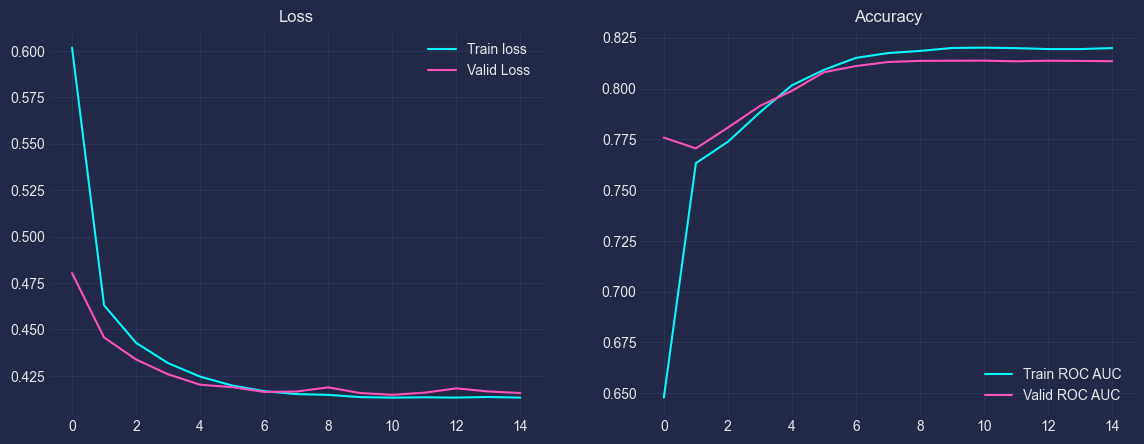

In [355]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

Лучший результат метрики ROC AUC на валидационной выборке достигается на 6-8 эпохах обучения однослойной неронной сети. Как и следовало ожидать этот результат равен результату работы логистической регрессии после оптимизации параметров.  

### 7. Выводы

В исходном датасете заполнены пропуски в признаках город и любимый жанр. Пропущенные значения любимого жанра заполнены модой с привязкой к городу. Также обработан признак дня начала триального периода пользователя, разбиением этого признака на 3 новых признака год, месяц, день.

Проведена разведка данных, которая показала, что с таргетом коррелирует только среднее число минут просмотра в день в течение триального периода. Также разведка данных покказала, что таргет имеет классовый дизбаланс. Задача представляет собой бинарную классификацию, в связи с этим лучше использовать ROC_AUC, f1_score, PR_AUC в качестве метрик для оценки модели.
  
Статистические тесты показали, что статистически значимыми признаками являются avg_min_watch_daily - среднее число минут просмотра в день в течение триального периода, number_of_days_logged - количество дней в течение триального пероида, когда пользователь логировался на сервисе.  
  
Сформировано 2 набора обучающих и валидационных данных:  
- с полным набором данных  
- с набором статистически значимых данных  
Данных закодированы TargetEncoder-от и отскалированы.
  
Обучены классические ML модели LogReg, RandomForest, CatBoost. Практика показала, что статистичесикм тестам можно доверять. Лучшие результаты показала линейная модель, что говорит о отсутствии сложных нелинейных связей. Проведена оптимизация LogReg. На валидационной выборке после оптимизации значение ROC AUC = 0.814.
Бустинг также можно было оптимизировать и достичь значение ROC AUC = 0.814, но в этом нет смысла, т.к. LogReg работает и обучается быстрее при равном качестве.
  
Построена и обучена однослойная нейронная сеть. Как и следовало ожидать, применение нейронной сети не привело к улучшению метрики, она также приобретает значение ROC AUC = 0.814 на 6-8 эпохах обучения.